In [7]:
from boxdetect import config



#Start with getting the default PipelinesConfig and adjusting it for your requirements and data:
cfg = config.PipelinesConfig()

#important to adjust these values to match the size of boxes on your image
cfg.width_range = (9,20)
cfg.height_range = (9,20)


# the more scaling factors the more accurate the results but also it takes more time to processing
# too small scaling factor may cause false positives
# too big scaling factor will take a lot of processing time
cfg.scaling_factors = [1.3]

# w/h ratio range for boxes/rectangles filtering
cfg.wh_ratio_range = (0.5, 1.5)

# group_size_range starting from 2 will skip all the groups
# with a single box detected inside (like checkboxes)
cfg.group_size_range = (1, 1)

# num of iterations when running dilation tranformation (to engance the image)
cfg.dilation_iterations = 0

In [8]:
from boxdetect import config
from pdf2image import convert_from_path
import numpy as np

# Convert PDF to image first (boxdetect needs image, not PDF)
pages = convert_from_path('output.pdf', dpi=200)  # or try 150, 300
img = np.array(pages[0])

cfg = config.PipelinesConfig()

# Adjust these based on your actual checkbox size at chosen DPI
cfg.width_range = (20, 40)   # Typical for 200 DPI
cfg.height_range = (20, 40)  # Typical for 200 DPI

# Multiple scaling factors for better detection
cfg.scaling_factors = [0.8, 1.0, 1.2, 1.5]

# Good for square/slightly rectangular checkboxes
cfg.wh_ratio_range = (0.8, 1.2)

# Keep these as is
cfg.group_size_range = (1, 1)
cfg.dilation_iterations = 0

# Additional settings for PDFs
cfg.blur_size = (1, 1)  # Minimal blur for sharp PDFs
cfg.morph_kernels_type = 'rectangles'

# Quick test script
from measure_for_boxdetect import measure_and_suggest_config
measure_and_suggest_config('output.pdf')

Analyzing output.pdf to suggest boxdetect config...

--- Testing at 200 DPI ---
Found 320 checkbox-like squares
Size range: 8-40 pixels
Average size: 15.9 pixels

Suggested boxdetect config for 200 DPI:
cfg.width_range = (4, 43)
cfg.height_range = (4, 43)

--- Testing at 300 DPI ---
Found 486 checkbox-like squares
Size range: 8-64 pixels
Average size: 24.1 pixels

Suggested boxdetect config for 300 DPI:
cfg.width_range = (4, 67)
cfg.height_range = (4, 67)

--- Recommended Configuration ---

from boxdetect import config

cfg = config.PipelinesConfig()

# Based on your PDF analysis
cfg.width_range = (15, 35)   # Adjust based on output above
cfg.height_range = (15, 35)  # Adjust based on output above

# For better accuracy with PDFs
cfg.scaling_factors = [1.0, 1.2, 1.5]  # Multiple scales for robustness

# For square checkboxes
cfg.wh_ratio_range = (0.8, 1.2)  # Allow slightly rectangular boxes

# For individual checkboxes
cfg.group_size_range = (1, 1)

# Minimal dilation for cleaner edge

True

In [9]:
from pdf2image import convert_from_path
import numpy as np
from PIL import Image

In [10]:
file_name = 'output.pdf'

# Convert PDF to PIL Images (all pages)
pages = convert_from_path(file_name)

# Convert first page to numpy array
img = np.array(pages[0])

print(f"Image shape: {img.shape}")

Image shape: (2339, 1653, 3)


In [11]:
from boxdetect.pipelines import get_boxes

rects, grouping_rects, image, output_image = get_boxes(
    img, cfg=cfg, plot=False)

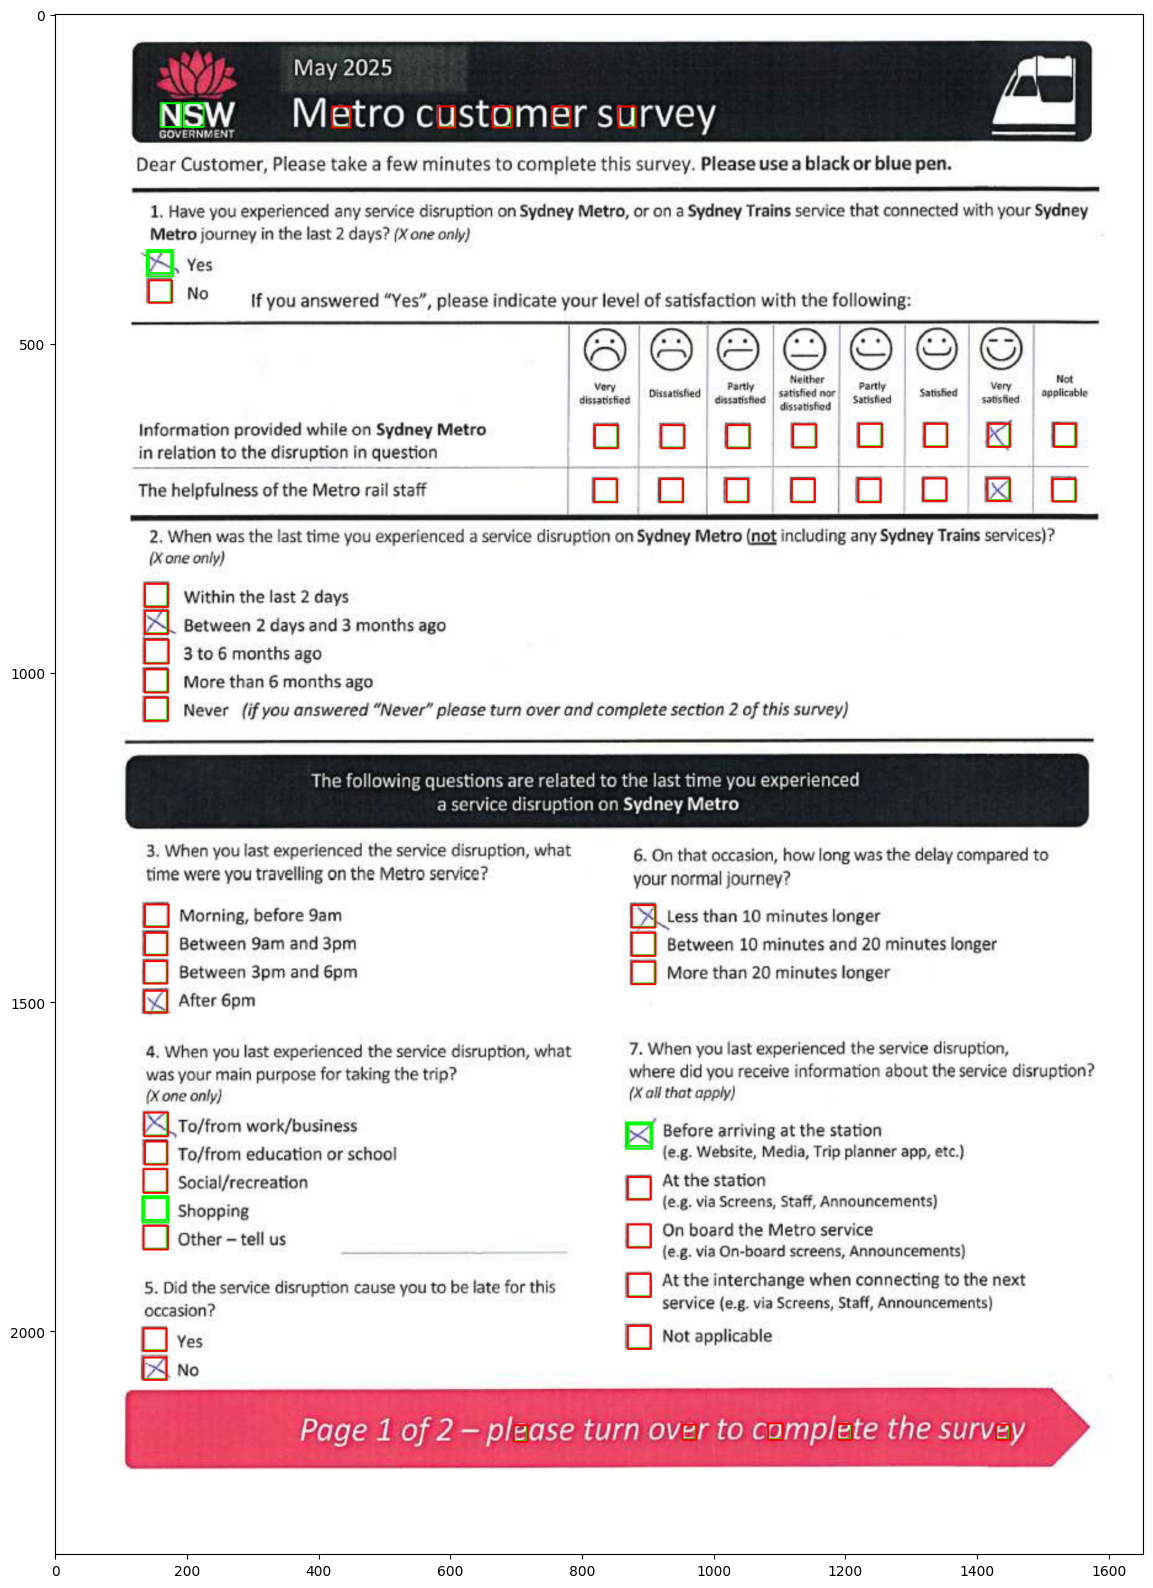

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
plt.imshow(output_image)
plt.show()

In [18]:
from boxdetect import config
from boxdetect.pipelines import get_boxes
from pdf2image import convert_from_path
import numpy as np
import cv2

# Your exact configuration
pages = convert_from_path('output.pdf', dpi=200)
img = np.array(pages[0])

cfg = config.PipelinesConfig()
cfg.width_range = (20, 40)
cfg.height_range = (20, 40)
cfg.scaling_factors = [0.8, 1.0, 1.2, 1.5]
cfg.wh_ratio_range = (0.8, 1.2)
cfg.group_size_range = (1, 1)
cfg.dilation_iterations = 0
cfg.blur_size = (1, 1)
cfg.morph_kernels_type = 'rectangles'

# Detect checkboxes
rects, groups, output_image, img_org = get_boxes(img, cfg)
print(f"Found {len(rects)} checkboxes")

#Cell 2: Fill Detection Function
def is_checkbox_filled(checkbox_region):
    """Check if checkbox has marks (not mostly empty space)"""

    # Convert to grayscale
    if len(checkbox_region.shape) == 3:
        gray = cv2.cvtColor(checkbox_region, cv2.COLOR_RGB2GRAY)
    else:
        gray = checkbox_region

    # Get inner area (avoid border lines)
    h, w = gray.shape
    margin = max(2, min(w, h) // 6)
    inner_region = gray[margin:h-margin, margin:w-margin]

    if inner_region.size == 0:
        return False, 0.0

    # Check for dark pixels (marks)
    dark_pixels = np.sum(inner_region < 200)  # Pixels darker than 200
    total_pixels = inner_region.size
    dark_ratio = dark_pixels / total_pixels

    # Check variance (marks create texture)
    variance = np.var(inner_region)

    # Combine for score
    fill_score = dark_ratio * 0.7 + min(1.0, variance / 1000) * 0.3

    # If more than 15% is "not empty space", consider it marked
    is_filled = fill_score > 0.15

    return is_filled, fill_score

Found 57 checkboxes


In [19]:
# Analyze each detected checkbox
filled_checkboxes = []

for i, rect in enumerate(rects):
    x, y, w, h = rect

    # Extract checkbox region
    checkbox_region = img[y:y+h, x:x+w]

    # Check if filled
    is_filled, fill_score = is_checkbox_filled(checkbox_region)

    filled_checkboxes.append({
        'id': i,
        'bbox': (x, y, w, h),
        'is_filled': is_filled,
        'fill_score': fill_score
    })

    print(f"Checkbox {i}: {'FILLED' if is_filled else 'EMPTY'} (score: {fill_score:.3f})")

# Summary
filled_count = sum(1 for cb in filled_checkboxes if cb['is_filled'])
print(f"\nSummary: {filled_count}/{len(filled_checkboxes)} checkboxes are filled")

Checkbox 0: FILLED (score: 0.530)
Checkbox 1: EMPTY (score: 0.001)
Checkbox 2: EMPTY (score: 0.001)
Checkbox 3: EMPTY (score: 0.001)
Checkbox 4: EMPTY (score: 0.001)
Checkbox 5: EMPTY (score: 0.001)
Checkbox 6: EMPTY (score: 0.002)
Checkbox 7: EMPTY (score: 0.002)
Checkbox 8: EMPTY (score: 0.002)
Checkbox 9: EMPTY (score: 0.002)
Checkbox 10: FILLED (score: 0.549)
Checkbox 11: FILLED (score: 0.508)
Checkbox 12: FILLED (score: 0.537)
Checkbox 13: FILLED (score: 0.520)
Checkbox 14: EMPTY (score: 0.000)
Checkbox 15: EMPTY (score: 0.001)
Checkbox 16: EMPTY (score: 0.001)
Checkbox 17: EMPTY (score: 0.002)
Checkbox 18: FILLED (score: 0.492)
Checkbox 19: EMPTY (score: 0.002)
Checkbox 20: EMPTY (score: 0.001)
Checkbox 21: EMPTY (score: 0.001)
Checkbox 22: EMPTY (score: 0.000)
Checkbox 23: FILLED (score: 0.547)
Checkbox 24: EMPTY (score: 0.000)
Checkbox 25: EMPTY (score: 0.001)
Checkbox 26: EMPTY (score: 0.000)
Checkbox 27: EMPTY (score: 0.000)
Checkbox 28: EMPTY (score: 0.001)
Checkbox 29: FILL

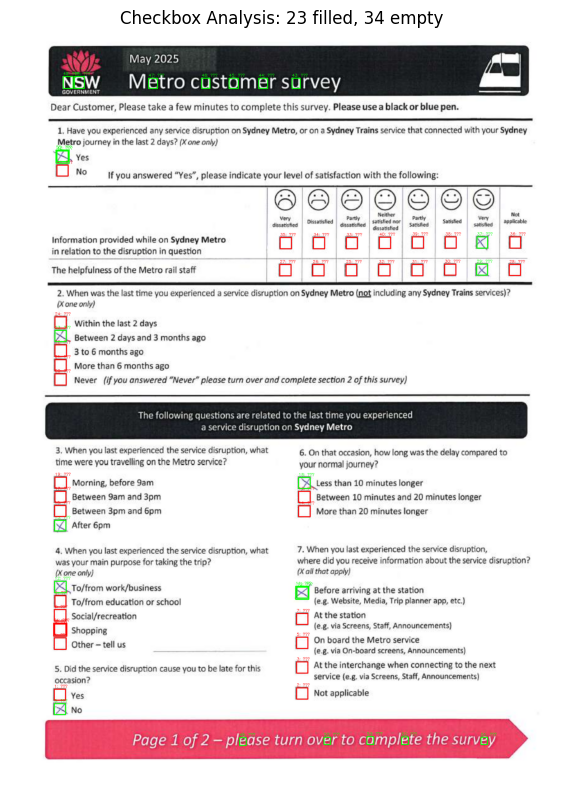

In [20]:
# Create visualization
result_img = img.copy()

for checkbox in filled_checkboxes:
    x, y, w, h = checkbox['bbox']
    is_filled = checkbox['is_filled']
    fill_score = checkbox['fill_score']

    # Green for filled, red for empty
    color = (0, 255, 0) if is_filled else (255, 0, 0)

    # Draw rectangle and label
    cv2.rectangle(result_img, (x, y), (x + w, y + h), color, 2)
    label = f"{checkbox['id']}: {'✓' if is_filled else '✗'}"
    cv2.putText(result_img, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

# Display result
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.imshow(result_img)
plt.title(f"Checkbox Analysis: {filled_count} filled, {len(filled_checkboxes)-filled_count} empty")
plt.axis('off')
plt.show()

In [24]:
# Get image dimensions
img_height, img_width = img.shape[:2]
print(f"Image dimensions: {img_width} x {img_height}")

# Define exclusion percentages
top_exclusion_percent = 10  # Exclude top 10%
bottom_exclusion_percent = 10  # Exclude bottom 5%

# Calculate coordinates for exclusion regions
exclusion_regions = []

# Top region (10%)
top_height = int(img_height * top_exclusion_percent / 100)
top_region = (0, 0, img_width, top_height)
exclusion_regions.append(top_region)
print(f"Top exclusion region (10%): {top_region}")

# Bottom region (5%)
bottom_height = int(img_height * bottom_exclusion_percent / 100)
bottom_y_start = img_height - bottom_height
bottom_region = (0, bottom_y_start, img_width, img_height)
exclusion_regions.append(bottom_region)
print(f"Bottom exclusion region (5%): {bottom_region}")

# You can add more regions here if needed:
# Left 5%: (0, 0, int(img_width * 0.05), img_height)
# Right 5%: (int(img_width * 0.95), 0, img_width, img_height)

# Add any additional manual regions here
additional_manual_regions = [
    # Example: exclude a specific area in the middle
    # (200, 300, 400, 500),  # (x_min, y_min, x_max, y_max)
]
exclusion_regions.extend(additional_manual_regions)

print(f"\nTotal exclusion regions: {len(exclusion_regions)}")
for i, region in enumerate(exclusion_regions):
    x1, y1, x2, y2 = region
    width = x2 - x1
    height = y2 - y1
    print(f"  Region {i+1}: ({x1}, {y1}, {x2}, {y2}) - {width}x{height} pixels")

def is_in_exclusion_region(bbox, exclusion_regions):
    """Check if checkbox overlaps with any exclusion region"""
    x, y, w, h = bbox
    checkbox_center_x = x + w // 2
    checkbox_center_y = y + h // 2

    for ex_x1, ex_y1, ex_x2, ex_y2 in exclusion_regions:
        # Check if checkbox center is within exclusion region
        if (ex_x1 <= checkbox_center_x <= ex_x2 and
            ex_y1 <= checkbox_center_y <= ex_y2):
            return True

    return False

# Filter out checkboxes in exclusion regions
filtered_checkboxes = []
excluded_checkboxes = []

for checkbox in filled_checkboxes:
    if is_in_exclusion_region(checkbox['bbox'], exclusion_regions):
        print(f"Excluding checkbox {checkbox['id']} at {checkbox['bbox']} - in exclusion region")
        excluded_checkboxes.append(checkbox)
    else:
        filtered_checkboxes.append(checkbox)

print(f"\nFiltering Results:")
print(f"Original checkboxes: {len(filled_checkboxes)}")
print(f"Excluded checkboxes: {len(excluded_checkboxes)}")
print(f"Remaining checkboxes: {len(filtered_checkboxes)}")

# Count filled checkboxes in remaining set
remaining_filled = sum(1 for cb in filtered_checkboxes if cb['is_filled'])
print(f"Filled checkboxes after exclusion: {remaining_filled}/{len(filtered_checkboxes)}")


Image dimensions: 1653 x 2339
Top exclusion region (10%): (0, 0, 1653, 233)
Bottom exclusion region (5%): (0, 2106, 1653, 2339)

Total exclusion regions: 2
  Region 1: (0, 0, 1653, 233) - 1653x233 pixels
  Region 2: (0, 2106, 1653, 2339) - 1653x233 pixels
Excluding checkbox 43 at (855, 140, 25, 31) - in exclusion region
Excluding checkbox 44 at (754, 140, 27, 31) - in exclusion region
Excluding checkbox 45 at (664, 140, 28, 31) - in exclusion region
Excluding checkbox 46 at (581, 140, 25, 31) - in exclusion region
Excluding checkbox 47 at (420, 140, 27, 31) - in exclusion region
Excluding checkbox 48 at (161, 135, 30, 36) - in exclusion region
Excluding checkbox 49 at (696, 2143, 20, 24) - in exclusion region
Excluding checkbox 50 at (952, 2142, 20, 22) - in exclusion region
Excluding checkbox 51 at (1428, 2142, 20, 22) - in exclusion region
Excluding checkbox 52 at (1187, 2141, 21, 23) - in exclusion region
Excluding checkbox 53 at (1082, 2140, 21, 24) - in exclusion region
Excluding 

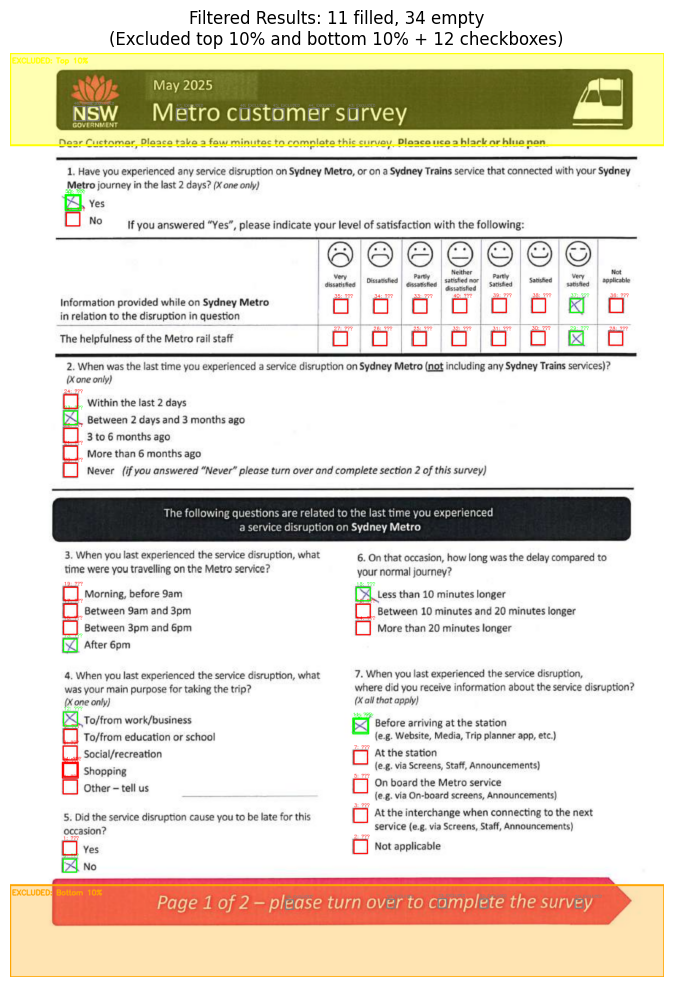

In [25]:

#Cell 6: Visualize with Percentage-Based Exclusions
# Visualize results with exclusion regions clearly marked
result_img_filtered = img.copy()

# Draw exclusion regions with different colors and labels
colors = [(255, 255, 0), (255, 165, 0), (255, 0, 255), (0, 255, 255)]  # Yellow, orange, magenta, cyan
region_names = [f"Top {top_exclusion_percent}%", f"Bottom {bottom_exclusion_percent}%"] + [f"Manual {i+1}" for i in
range(len(additional_manual_regions))]

for i, ((ex_x1, ex_y1, ex_x2, ex_y2), color, name) in enumerate(zip(exclusion_regions, colors, region_names)):
    # Draw semi-transparent overlay
    overlay = result_img_filtered.copy()
    cv2.rectangle(overlay, (ex_x1, ex_y1), (ex_x2, ex_y2), color, -1)
    cv2.addWeighted(overlay, 0.3, result_img_filtered, 0.7, 0, result_img_filtered)

    # Draw border
    cv2.rectangle(result_img_filtered, (ex_x1, ex_y1), (ex_x2, ex_y2), color, 3)

    # Add label
    label_y = ex_y1 + 25 if ex_y1 + 25 < img_height else ex_y1 - 10
    cv2.putText(result_img_filtered, f"EXCLUDED: {name}", (ex_x1 + 5, label_y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

# Draw remaining checkboxes
for checkbox in filtered_checkboxes:
    x, y, w, h = checkbox['bbox']
    is_filled = checkbox['is_filled']

    # Green for filled, red for empty
    color = (0, 255, 0) if is_filled else (255, 0, 0)

    cv2.rectangle(result_img_filtered, (x, y), (x + w, y + h), color, 2)
    label = f"{checkbox['id']}: {'✓' if is_filled else '✗'}"
    cv2.putText(result_img_filtered, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

# Draw excluded checkboxes in gray
for checkbox in excluded_checkboxes:
    x, y, w, h = checkbox['bbox']
    cv2.rectangle(result_img_filtered, (x, y), (x + w, y + h), (128, 128, 128), 2)
    label = f"{checkbox['id']}: EXCLUDED"
    cv2.putText(result_img_filtered, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (128, 128, 128), 1)

# Display filtered result
plt.figure(figsize=(16, 12))
plt.imshow(result_img_filtered)
plt.title(f"Filtered Results: {remaining_filled} filled, {len(filtered_checkboxes)-remaining_filled} empty\n(Excluded top {top_exclusion_percent}% and bottom {bottom_exclusion_percent}% + {len(excluded_checkboxes)} checkboxes)")
plt.axis('off')
plt.show()

In [26]:
import pandas as pd

# Sort checkboxes by their position (top-to-bottom, left-to-right reading order)
def sort_checkboxes_by_position(checkboxes):
    """Sort checkboxes in reading order: top-to-bottom, then left-to-right"""
    return sorted(checkboxes, key=lambda cb: (cb['bbox'][1], cb['bbox'][0]))  # Sort by y, then x

# Sort the filtered checkboxes in reading order
sorted_checkboxes = sort_checkboxes_by_position(filtered_checkboxes)

# Create column names
column_names = [f"box{i+1}" for i in range(len(sorted_checkboxes))]

# Create the data row with True/False values
checkbox_values = [checkbox['is_filled'] for checkbox in sorted_checkboxes]

# Create DataFrame
df = pd.DataFrame([checkbox_values], columns=column_names)

print("Checkbox Results DataFrame:")
print("=" * 50)
print(df)

# Also show detailed information
print(f"\nDetailed Checkbox Information:")
print("=" * 50)
for i, checkbox in enumerate(sorted_checkboxes):
    x, y, w, h = checkbox['bbox']
    status = "✓ FILLED" if checkbox['is_filled'] else "✗ EMPTY"
    fill_score = checkbox['fill_score']
    print(f"box{i+1}: {status} (score: {fill_score:.3f}) - Position: ({x}, {y})")

# Summary statistics
filled_count = sum(checkbox_values)
total_count = len(checkbox_values)
print(f"\nSummary:")
print(f"Total boxes: {total_count}")
print(f"Filled boxes: {filled_count}")
print(f"Empty boxes: {total_count - filled_count}")
print(f"Fill rate: {filled_count/total_count*100:.1f}%")


Checkbox Results DataFrame:
   box1  box2   box3   box4   box5  box6   box7   box8   box9  box10  ...  \
0  True  True  False  False  False  True  False  False  False  False  ...   

   box36  box37  box38  box39  box40  box41  box42  box43  box44  box45  
0  False  False  False  False  False  False  False  False  False   True  

[1 rows x 45 columns]

Detailed Checkbox Information:
box1: ✓ FILLED (score: 0.485) - Position: (139, 358)
box2: ✓ FILLED (score: 0.527) - Position: (142, 361)
box3: ✗ EMPTY (score: 0.000) - Position: (142, 404)
box4: ✗ EMPTY (score: 0.000) - Position: (1220, 622)
box5: ✗ EMPTY (score: 0.000) - Position: (1320, 622)
box6: ✓ FILLED (score: 0.512) - Position: (1416, 622)
box7: ✗ EMPTY (score: 0.000) - Position: (1516, 622)
box8: ✗ EMPTY (score: 0.000) - Position: (1120, 623)
box9: ✗ EMPTY (score: 0.001) - Position: (819, 624)
box10: ✗ EMPTY (score: 0.000) - Position: (920, 624)
box11: ✗ EMPTY (score: 0.001) - Position: (1020, 624)
box12: ✗ EMPTY (score: 0.002) -

In [27]:
# Save to CSV file
csv_filename = "checkbox_results.csv"
df.to_csv(csv_filename, index=False)
print(f"Results saved to: {csv_filename}")

# Also save with additional metadata
detailed_df = pd.DataFrame({
    'box_id': [f"box{i+1}" for i in range(len(sorted_checkboxes))],
    'is_filled': [cb['is_filled'] for cb in sorted_checkboxes],
    'fill_score': [cb['fill_score'] for cb in sorted_checkboxes],
    'position_x': [cb['bbox'][0] for cb in sorted_checkboxes],
    'position_y': [cb['bbox'][1] for cb in sorted_checkboxes],
    'width': [cb['bbox'][2] for cb in sorted_checkboxes],
    'height': [cb['bbox'][3] for cb in sorted_checkboxes]
})

detailed_csv_filename = "checkbox_results_detailed.csv"
detailed_df.to_csv(detailed_csv_filename, index=False)
print(f"Detailed results saved to: {detailed_csv_filename}")

print(f"\nDataFrame preview:")
print(df)
print(f"\nDetailed DataFrame preview:")
print(detailed_df.head())



Results saved to: checkbox_results.csv
Detailed results saved to: checkbox_results_detailed.csv

DataFrame preview:
   box1  box2   box3   box4   box5  box6   box7   box8   box9  box10  ...  \
0  True  True  False  False  False  True  False  False  False  False  ...   

   box36  box37  box38  box39  box40  box41  box42  box43  box44  box45  
0  False  False  False  False  False  False  False  False  False   True  

[1 rows x 45 columns]

Detailed DataFrame preview:
  box_id  is_filled  fill_score  position_x  position_y  width  height
0   box1       True    0.484821         139         358     40      40
1   box2       True    0.526705         142         361     34      32
2   box3      False    0.000476         142         404     34      33
3   box4      False    0.000094        1220         622     34      34
4   box5      False    0.000311        1320         622     33      34


In [29]:
detailed_df.head()

box_id  is_filled  fill_score  position_x  position_y  width  height
0   box1       True    0.484821         139         358     40      40
1   box2       True    0.526705         142         361     34      32
2   box3      False    0.000476         142         404     34      33
3   box4      False    0.000094        1220         622     34      34
4   box5      False    0.000311        1320         622     33      34

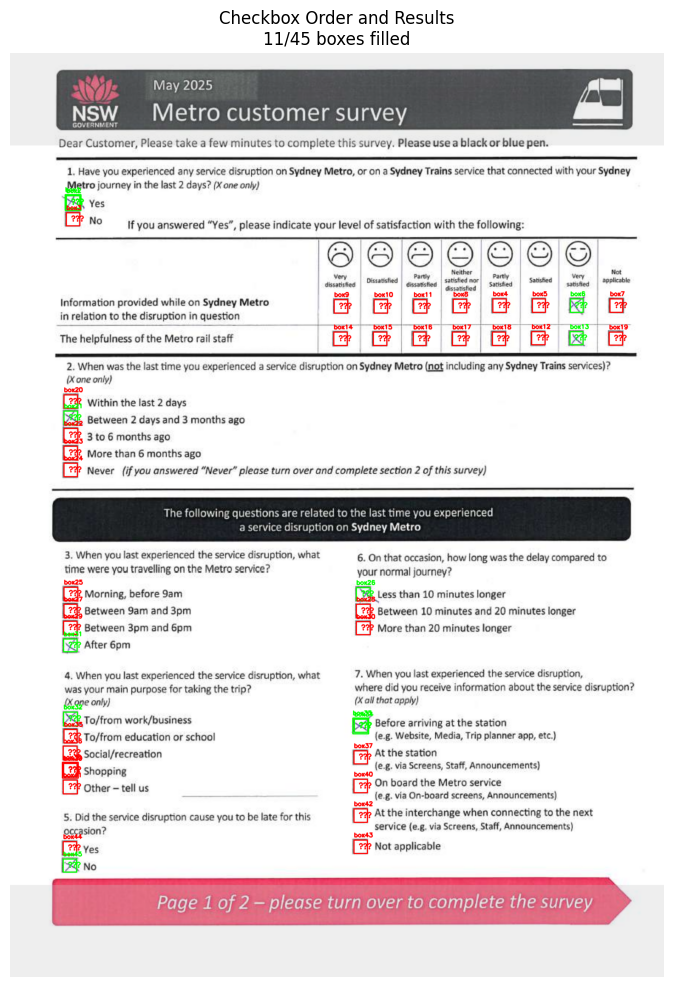

Box ordering: top-to-bottom, then left-to-right
DataFrame columns: ['box1', 'box2', 'box3', 'box4', 'box5', 'box6', 'box7', 'box8', 'box9', 'box10', 'box11', 'box12', 'box13', 'box14', 'box15', 'box16', 'box17', 'box18', 'box19', 'box20', 'box21', 'box22', 'box23', 'box24', 'box25', 'box26', 'box27', 'box28', 'box29', 'box30', 'box31', 'box32', 'box33', 'box34', 'box35', 'box36', 'box37', 'box38', 'box39', 'box40', 'box41', 'box42', 'box43', 'box44', 'box45']
Values: [True, True, False, False, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, False, True, False, False, False, False, True, False, False, False, False, True, True, True, True, False, False, False, False, False, False, False, False, False, False, True]


In [28]:

# Create visualization showing the box numbering order
numbered_img = img.copy()

# Draw exclusion regions (faded)
for ex_x1, ex_y1, ex_x2, ex_y2 in exclusion_regions:
    overlay = numbered_img.copy()
    cv2.rectangle(overlay, (ex_x1, ex_y1), (ex_x2, ex_y2), (200, 200, 200), -1)
    cv2.addWeighted(overlay, 0.3, numbered_img, 0.7, 0, numbered_img)

# Draw sorted checkboxes with their box numbers
for i, checkbox in enumerate(sorted_checkboxes):
    x, y, w, h = checkbox['bbox']
    is_filled = checkbox['is_filled']

    # Color: Green for filled, red for empty
    color = (0, 255, 0) if is_filled else (255, 0, 0)

    # Draw rectangle
    cv2.rectangle(numbered_img, (x, y), (x + w, y + h), color, 2)

    # Draw box number prominently
    box_number = f"box{i+1}"
    cv2.putText(numbered_img, box_number, (x, y - 8),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Draw fill status
    status_symbol = "✓" if is_filled else "✗"
    cv2.putText(numbered_img, status_symbol, (x + w//2 - 5, y + h//2 + 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

plt.figure(figsize=(16, 12))
plt.imshow(numbered_img)
plt.title(f"Checkbox Order and Results\n{filled_count}/{total_count} boxes filled")
plt.axis('off')
plt.show()

print(f"Box ordering: top-to-bottom, then left-to-right")
print(f"DataFrame columns: {list(df.columns)}")
print(f"Values: {list(df.iloc[0])}")

In [30]:
def calculate_overlap_ratio(box1, box2):
    """Calculate overlap ratio between two boxes"""
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculate intersection
    left = max(x1, x2)
    top = max(y1, y2)
    right = min(x1 + w1, x2 + w2)
    bottom = min(y1 + h1, y2 + h2)

    if left < right and top < bottom:
        intersection = (right - left) * (bottom - top)
        area1 = w1 * h1
        area2 = w2 * h2
        union = area1 + area2 - intersection

        # Return overlap as ratio of intersection to smaller box
        smaller_area = min(area1, area2)
        overlap_ratio = intersection / smaller_area if smaller_area > 0 else 0

        return overlap_ratio
    return 0

def remove_overlapping_boxes(checkboxes, overlap_threshold=0.5):
    """Remove overlapping boxes, keeping the 'better' one"""

    if not checkboxes:
        return checkboxes

    print(f"Original boxes: {len(checkboxes)}")

    # Sort by fill score first (keep higher confidence detections)
    sorted_boxes = sorted(checkboxes, key=lambda x: x['fill_score'], reverse=True)

    filtered_boxes = []
    removed_boxes = []

    for current_box in sorted_boxes:
        is_duplicate = False

        for kept_box in filtered_boxes:
            overlap = calculate_overlap_ratio(current_box['bbox'], kept_box['bbox'])

            if overlap > overlap_threshold:
                print(f"Removing overlapping box {current_box['id']} (overlap: {overlap:.2f} with box {kept_box['id']})")
                removed_boxes.append(current_box)
                is_duplicate = True
                break

        if not is_duplicate:
            filtered_boxes.append(current_box)

    print(f"Filtered boxes: {len(filtered_boxes)}")
    print(f"Removed {len(removed_boxes)} overlapping boxes")

    return filtered_boxes, removed_boxes

# Apply overlap filtering to our filtered checkboxes
deduplicated_checkboxes, removed_overlaps = remove_overlapping_boxes(filtered_checkboxes, overlap_threshold=0.5)

print(f"\nDeduplication Results:")
print(f"Before: {len(filtered_checkboxes)} boxes")
print(f"After: {len(deduplicated_checkboxes)} boxes")
print(f"Removed overlaps: {len(removed_overlaps)} boxes")

# Count filled boxes in deduplicated set
deduplicated_filled = sum(1 for cb in deduplicated_checkboxes if cb['is_filled'])
print(f"Filled boxes after deduplication: {deduplicated_filled}")

# Show which boxes were removed
if removed_overlaps:
    print(f"\nRemoved overlapping boxes:")
    for box in removed_overlaps:
        x, y, w, h = box['bbox']
        status = "FILLED" if box['is_filled'] else "EMPTY"
        print(f"  Box {box['id']}: {status} at ({x}, {y}) - fill_score: {box['fill_score']:.3f}")


Original boxes: 45
Removing overlapping box 11 (overlap: 1.00 with box 10)
Removing overlapping box 55 (overlap: 1.00 with box 42)
Removing overlapping box 6 (overlap: 1.00 with box 54)
Filtered boxes: 42
Removed 3 overlapping boxes

Deduplication Results:
Before: 45 boxes
After: 42 boxes
Removed overlaps: 3 boxes
Filled boxes after deduplication: 9

Removed overlapping boxes:
  Box 11: FILLED at (866, 1683) - fill_score: 0.508
  Box 55: FILLED at (139, 358) - fill_score: 0.485
  Box 6: EMPTY at (135, 1798) - fill_score: 0.002


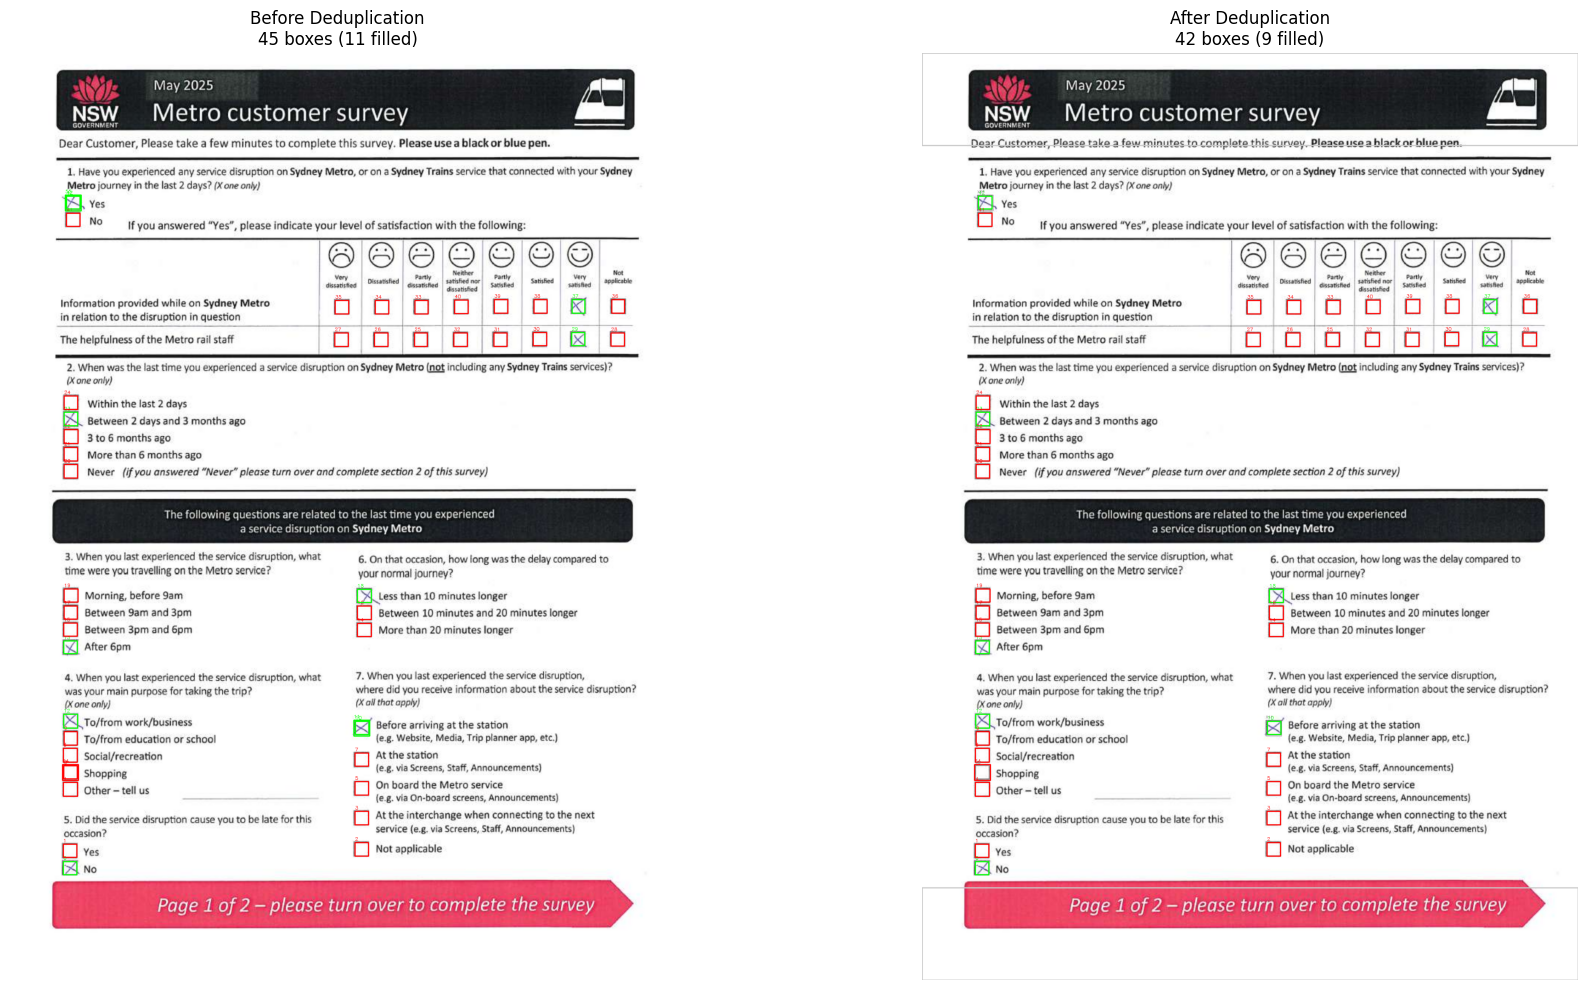

Overlap threshold used: 50% (boxes with >50% overlap are considered duplicates)
You can adjust this by changing overlap_threshold in the function call


In [31]:
# Create side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Before deduplication
img_before = img.copy()
for checkbox in filtered_checkboxes:
    x, y, w, h = checkbox['bbox']
    color = (0, 255, 0) if checkbox['is_filled'] else (255, 0, 0)
    cv2.rectangle(img_before, (x, y), (x + w, y + h), color, 2)
    cv2.putText(img_before, str(checkbox['id']), (x, y - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

ax1.imshow(img_before)
ax1.set_title(f"Before Deduplication\n{len(filtered_checkboxes)} boxes ({sum(1 for cb in filtered_checkboxes if cb['is_filled'])} filled)")
ax1.axis('off')

# After deduplication
img_after = img.copy()

# Draw exclusion regions lightly
for ex_x1, ex_y1, ex_x2, ex_y2 in exclusion_regions:
    cv2.rectangle(img_after, (ex_x1, ex_y1), (ex_x2, ex_y2), (200, 200, 200), 2)

# Draw kept boxes
for checkbox in deduplicated_checkboxes:
    x, y, w, h = checkbox['bbox']
    color = (0, 255, 0) if checkbox['is_filled'] else (255, 0, 0)
    cv2.rectangle(img_after, (x, y), (x + w, y + h), color, 2)
    cv2.putText(img_after, str(checkbox['id']), (x, y - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

# Draw removed boxes in gray
for checkbox in removed_overlaps:
    x, y, w, h = checkbox['bbox']
    cv2.rectangle(img_after, (x, y), (x + w, y + h), (128, 128, 128), 1)
    cv2.putText(img_after, f"X{checkbox['id']}", (x, y - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (128, 128, 128), 1)

ax2.imshow(img_after)
ax2.set_title(f"After Deduplication\n{len(deduplicated_checkboxes)} boxes ({deduplicated_filled} filled)")
ax2.axis('off')

plt.tight_layout()
plt.show()

print(f"Overlap threshold used: 50% (boxes with >50% overlap are considered duplicates)")
print(f"You can adjust this by changing overlap_threshold in the function call")

In [32]:
# Create final DataFrame with deduplicated results
import pandas as pd

# Sort deduplicated checkboxes by position
final_sorted_checkboxes = sort_checkboxes_by_position(deduplicated_checkboxes)

# Create column names
final_column_names = [f"box{i+1}" for i in range(len(final_sorted_checkboxes))]

# Create the data row with True/False values
final_checkbox_values = [checkbox['is_filled'] for checkbox in final_sorted_checkboxes]

# Create final DataFrame
final_df = pd.DataFrame([final_checkbox_values], columns=final_column_names)

print("Final Checkbox Results DataFrame (After Deduplication):")
print("=" * 60)
print(final_df)

# Show detailed information
print(f"\nFinal Detailed Checkbox Information:")
print("=" * 60)
for i, checkbox in enumerate(final_sorted_checkboxes):
    x, y, w, h = checkbox['bbox']
    status = "✓ FILLED" if checkbox['is_filled'] else "✗ EMPTY"
    fill_score = checkbox['fill_score']
    print(f"box{i+1}: {status} (score: {fill_score:.3f}) - Position: ({x}, {y})")

# Final summary
final_filled_count = sum(final_checkbox_values)
final_total_count = len(final_checkbox_values)
print(f"\nFinal Summary:")
print(f"Total unique boxes: {final_total_count}")
print(f"Filled boxes: {final_filled_count}")
print(f"Empty boxes: {final_total_count - final_filled_count}")
print(f"Fill rate: {final_filled_count/final_total_count*100:.1f}%")

# Save final results
final_df.to_csv("final_checkbox_results.csv", index=False)
print(f"\nFinal results saved to: final_checkbox_results.csv")

Final Checkbox Results DataFrame (After Deduplication):
   box1   box2   box3   box4  box5   box6   box7   box8   box9  box10  ...  \
0  True  False  False  False  True  False  False  False  False  False  ...   

   box33  box34  box35  box36  box37  box38  box39  box40  box41  box42  
0  False  False  False  False  False  False  False  False  False   True  

[1 rows x 42 columns]

Final Detailed Checkbox Information:
box1: ✓ FILLED (score: 0.527) - Position: (142, 361)
box2: ✗ EMPTY (score: 0.000) - Position: (142, 404)
box3: ✗ EMPTY (score: 0.000) - Position: (1220, 622)
box4: ✗ EMPTY (score: 0.000) - Position: (1320, 622)
box5: ✓ FILLED (score: 0.512) - Position: (1416, 622)
box6: ✗ EMPTY (score: 0.000) - Position: (1516, 622)
box7: ✗ EMPTY (score: 0.000) - Position: (1120, 623)
box8: ✗ EMPTY (score: 0.001) - Position: (819, 624)
box9: ✗ EMPTY (score: 0.000) - Position: (920, 624)
box10: ✗ EMPTY (score: 0.001) - Position: (1020, 624)
box11: ✗ EMPTY (score: 0.002) - Position: (1318, 

In [ ]:
import json

# Create a mapping interface for custom column names
def create_column_mapping(checkboxes):
    """Interactive function to create custom column names for checkboxes"""

    print("Custom Column Name Assignment")
    print("=" * 40)
    print("Current boxes (in order):")

    # Show current box positions for reference
    for i, checkbox in enumerate(checkboxes):
        x, y, w, h = checkbox['bbox']
        status = "✓ FILLED" if checkbox['is_filled'] else "✗ EMPTY"
        print(f"  box{i+1}: {status} - Position: ({x}, {y})")

    print(f"\nEnter custom names for each box (or press Enter to keep default):")
    print("Examples: 'name', 'age_under_18', 'agrees_terms', 'option_a', etc.")

    column_mapping = {}

    for i, checkbox in enumerate(checkboxes):
        default_name = f"box{i+1}"
        x, y, w, h = checkbox['bbox']
        status = "FILLED" if checkbox['is_filled'] else "EMPTY"

        prompt = f"\nbox{i+1} ({status}) at ({x}, {y}): "
        custom_name = input(prompt).strip()

        if custom_name:
            # Clean the name (replace spaces with underscores, remove special chars)
            clean_name = custom_name.replace(' ', '_').replace('-', '_')
            clean_name = ''.join(c for c in clean_name if c.isalnum() or c == '_')
            column_mapping[default_name] = clean_name
            print(f"  → Saved as: '{clean_name}'")
        else:
            column_mapping[default_name] = default_name
            print(f"  → Keeping default: '{default_name}'")

    return column_mapping

# Alternative: Define column names manually (skip interactive input)
def create_manual_column_mapping(checkboxes):
    """Manually define column names - edit this list as needed"""

    # EDIT THESE NAMES TO MATCH YOUR FORM:
    custom_names = [
        "1, Yes",
        "1. No",
        
        
    ]

    column_mapping = {}

    for i, checkbox in enumerate(checkboxes):
        default_name = f"box{i+1}"

        if i < len(custom_names):
            custom_name = custom_names[i]
        else:
            custom_name = f"box{i+1}"  # Fall back to default if not enough names

        column_mapping[default_name] = custom_name
        print(f"box{i+1} → '{custom_name}'")

    return column_mapping

# Choose your method:
print("Choose column naming method:")
print("1. Interactive (you'll be prompted for each box)")
print("2. Manual (edit the list in the code)")
print("3. Keep defaults (box1, box2, etc.)")

choice = input("Enter choice (1/2/3): ").strip()

if choice == "1":
    column_mapping = create_column_mapping(final_sorted_checkboxes)
elif choice == "2":
    column_mapping = create_manual_column_mapping(final_sorted_checkboxes)
else:
    # Keep defaults
    column_mapping = {f"box{i+1}": f"box{i+1}" for i in range(len(final_sorted_checkboxes))}
    print("Keeping default column names")

print(f"\nColumn Mapping:")
for old_name, new_name in column_mapping.items():
    print(f"  {old_name} → {new_name}")

Choose column naming method:
1. Interactive (you'll be prompted for each box)
2. Manual (edit the list in the code)
3. Keep defaults (box1, box2, etc.)
box1 → '1, Yes'
box2 → '1. No'
box3 → 'box3'
box4 → 'box4'
box5 → 'box5'
box6 → 'box6'
box7 → 'box7'
box8 → 'box8'
box9 → 'box9'
box10 → 'box10'
box11 → 'box11'
box12 → 'box12'
box13 → 'box13'
box14 → 'box14'
box15 → 'box15'
box16 → 'box16'
box17 → 'box17'
box18 → 'box18'
box19 → 'box19'
box20 → 'box20'
box21 → 'box21'
box22 → 'box22'
box23 → 'box23'
box24 → 'box24'
box25 → 'box25'
box26 → 'box26'
box27 → 'box27'
box28 → 'box28'
box29 → 'box29'
box30 → 'box30'
box31 → 'box31'
box32 → 'box32'
box33 → 'box33'
box34 → 'box34'
box35 → 'box35'
box36 → 'box36'
box37 → 'box37'
box38 → 'box38'
box39 → 'box39'
box40 → 'box40'
box41 → 'box41'
box42 → 'box42'

Column Mapping:
  box1 → 1, Yes
  box2 → 1. No
  box3 → box3
  box4 → box4
  box5 → box5
  box6 → box6
  box7 → box7
  box8 → box8
  box9 → box9
  box10 → box10
  box11 → box11
  box12 → box

In [34]:
# Save column mapping to JSON file for future use
mapping_filename = "checkbox_column_mapping.json"

# Create enhanced mapping with position info for future reference
enhanced_mapping = {}
for i, checkbox in enumerate(final_sorted_checkboxes):
    box_id = f"box{i+1}"
    x, y, w, h = checkbox['bbox']

    enhanced_mapping[box_id] = {
        "column_name": column_mapping[box_id],
        "position": {"x": int(x), "y": int(y), "width": int(w), "height": int(h)},
        "original_id": int(checkbox['id']),
        "fill_score": float(checkbox['fill_score'])
    }

# Save to JSON
with open(mapping_filename, 'w') as f:
    json.dump(enhanced_mapping, f, indent=2)

print(f"Column mapping saved to: {mapping_filename}")

# Create DataFrame with custom column names
custom_column_names = [column_mapping[f"box{i+1}"] for i in range(len(final_sorted_checkboxes))]
custom_checkbox_values = [checkbox['is_filled'] for checkbox in final_sorted_checkboxes]

# Create final DataFrame with custom names
custom_df = pd.DataFrame([custom_checkbox_values], columns=custom_column_names)

print(f"\nFinal DataFrame with Custom Column Names:")
print("=" * 60)
print(custom_df)

# Save the custom DataFrame
custom_df.to_csv("checkbox_results_custom_names.csv", index=False)
print(f"\nCustom results saved to: checkbox_results_custom_names.csv")

# Also create a detailed mapping CSV for reference
mapping_df = pd.DataFrame([
    {
        'box_number': box_id,
        'column_name': info['column_name'],
        'position_x': info['position']['x'],
        'position_y': info['position']['y'],
        'is_filled': custom_checkbox_values[i],
        'fill_score': info['fill_score']
    }
    for i, (box_id, info) in enumerate(enhanced_mapping.items())
])

mapping_df.to_csv("checkbox_mapping_reference.csv", index=False)
print(f"Mapping reference saved to: checkbox_mapping_reference.csv")

Column mapping saved to: checkbox_column_mapping.json

Final DataFrame with Custom Column Names:
   box1   box2   box3   box4  box5   box6   box7   box8   box9  box10  ...  \
0  True  False  False  False  True  False  False  False  False  False  ...   

   box33  box34  box35  box36  box37  box38  box39  box40  box41  box42  
0  False  False  False  False  False  False  False  False  False   True  

[1 rows x 42 columns]

Custom results saved to: checkbox_results_custom_names.csv
Mapping reference saved to: checkbox_mapping_reference.csv


In [36]:
def load_column_mapping(mapping_file="checkbox_column_mapping.json"):
    """Load previously saved column mapping"""
    try:
        with open(mapping_file, 'r') as f:
            saved_mapping = json.load(f)

        print(f"Loaded column mapping from: {mapping_file}")
        print("Saved mapping:")
        for box_id, info in saved_mapping.items():
            print(f"  {box_id} → '{info['column_name']}' at ({info['position']['x']}, {info['position']['y']})")

        return saved_mapping
    except FileNotFoundError:
        print(f"No saved mapping found at: {mapping_file}")
        return None

def apply_saved_mapping(checkboxes, saved_mapping):
    """Apply saved column mapping to new checkbox results"""

    if not saved_mapping:
        return None

    # Try to match checkboxes by position (with some tolerance)
    def find_matching_box(checkbox, saved_mapping, tolerance=20):
        x, y, w, h = checkbox['bbox']

        for box_id, info in saved_mapping.items():
            saved_x = info['position']['x']
            saved_y = info['position']['y']

            # Check if positions are close
            if (abs(x - saved_x) <= tolerance and abs(y - saved_y) <= tolerance):
                return info['column_name']

        return None

    # Create mapping for current checkboxes
    column_names = []
    for i, checkbox in enumerate(checkboxes):
        matched_name = find_matching_box(checkbox, saved_mapping)
        if matched_name:
            column_names.append(matched_name)
            print(f"box{i+1} matched to saved column: '{matched_name}'")
        else:
            column_names.append(f"box{i+1}")
            print(f"box{i+1} no match found, using default name")

    return column_names

# Example usage for future processing:
print("For future use, you can load the saved mapping like this:")
print("saved_mapping = load_column_mapping()")
print("column_names = apply_saved_mapping(final_sorted_checkboxes, saved_mapping)")

# Show the JSON structure
print(f"\nSaved JSON structure preview:")
if enhanced_mapping:
    first_key = list(enhanced_mapping.keys())[0]
    print(f"'{first_key}': {json.dumps(enhanced_mapping[first_key], indent=2)}")

For future use, you can load the saved mapping like this:
saved_mapping = load_column_mapping()
column_names = apply_saved_mapping(final_sorted_checkboxes, saved_mapping)

Saved JSON structure preview:
'box1': {
  "column_name": "box1",
  "position": {
    "x": 142,
    "y": 361,
    "width": 34,
    "height": 32
  },
  "original_id": 42,
  "fill_score": 0.5267045454545454
}


In [37]:
# Sort checkboxes by Y coordinate (top to bottom), then X coordinate (left to right)
def sort_checkboxes_top_to_bottom(checkboxes):
    """Sort checkboxes: highest Y first (top), then left to right"""
    return sorted(checkboxes, key=lambda cb: (cb['bbox'][1], cb['bbox'][0]))

# Re-sort the deduplicated checkboxes
final_sorted_checkboxes = sort_checkboxes_top_to_bottom(deduplicated_checkboxes)

print("Reordered checkboxes (top-to-bottom, left-to-right):")
for i, checkbox in enumerate(final_sorted_checkboxes):
    x, y, w, h = checkbox['bbox']
    status = "✓ FILLED" if checkbox['is_filled'] else "✗ EMPTY"
    print(f"box{i+1}: {status} - Y:{y}, X:{x}")

# Update DataFrame with new order
final_column_names = [f"box{i+1}" for i in range(len(final_sorted_checkboxes))]
final_checkbox_values = [checkbox['is_filled'] for checkbox in final_sorted_checkboxes]
final_df = pd.DataFrame([final_checkbox_values], columns=final_column_names)

print(f"\nUpdated DataFrame (top-to-bottom order):")
print(final_df)

Reordered checkboxes (top-to-bottom, left-to-right):
box1: ✓ FILLED - Y:361, X:142
box2: ✗ EMPTY - Y:404, X:142
box3: ✗ EMPTY - Y:622, X:1220
box4: ✗ EMPTY - Y:622, X:1320
box5: ✓ FILLED - Y:622, X:1416
box6: ✗ EMPTY - Y:622, X:1516
box7: ✗ EMPTY - Y:623, X:1120
box8: ✗ EMPTY - Y:624, X:819
box9: ✗ EMPTY - Y:624, X:920
box10: ✗ EMPTY - Y:624, X:1020
box11: ✗ EMPTY - Y:705, X:1318
box12: ✓ FILLED - Y:705, X:1415
box13: ✗ EMPTY - Y:706, X:818
box14: ✗ EMPTY - Y:706, X:918
box15: ✗ EMPTY - Y:706, X:1019
box16: ✗ EMPTY - Y:706, X:1118
box17: ✗ EMPTY - Y:706, X:1219
box18: ✗ EMPTY - Y:706, X:1514
box19: ✗ EMPTY - Y:865, X:136
box20: ✓ FILLED - Y:906, X:136
box21: ✗ EMPTY - Y:950, X:136
box22: ✗ EMPTY - Y:995, X:136
box23: ✗ EMPTY - Y:1038, X:136
box24: ✗ EMPTY - Y:1352, X:136
box25: ✓ FILLED - Y:1353, X:875
box26: ✗ EMPTY - Y:1395, X:136
box27: ✗ EMPTY - Y:1395, X:875
box28: ✗ EMPTY - Y:1438, X:135
box29: ✗ EMPTY - Y:1439, X:875
box30: ✓ FILLED - Y:1483, X:135
box31: ✓ FILLED - Y:1668, X:13

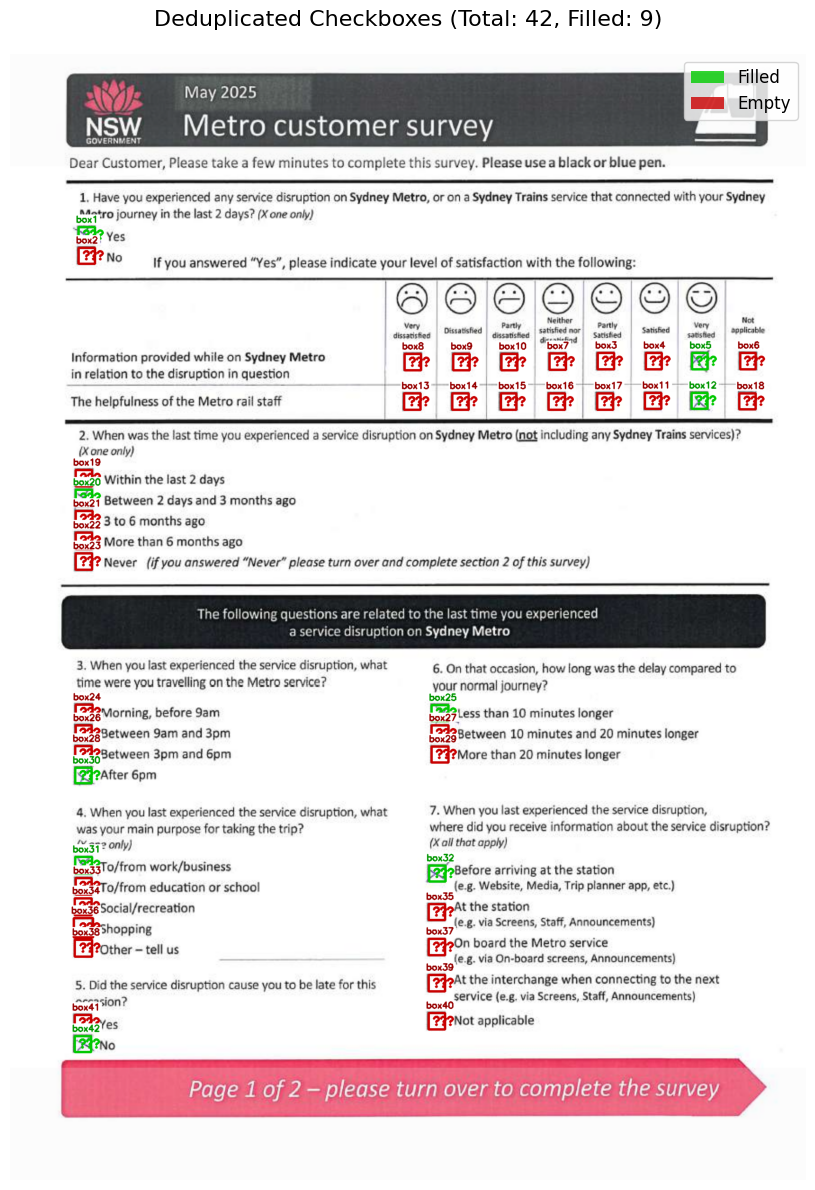

Summary of 42 detected checkboxes:
--------------------------------------------------
box1: FILLED at position (142, 361)
box2: EMPTY  at position (142, 404)
box3: EMPTY  at position (1220, 622)
box4: EMPTY  at position (1320, 622)
box5: FILLED at position (1416, 622)
box6: EMPTY  at position (1516, 622)
box7: EMPTY  at position (1120, 623)
box8: EMPTY  at position (819, 624)
box9: EMPTY  at position (920, 624)
box10: EMPTY  at position (1020, 624)
box11: EMPTY  at position (1318, 705)
box12: FILLED at position (1415, 705)
box13: EMPTY  at position (818, 706)
box14: EMPTY  at position (918, 706)
box15: EMPTY  at position (1019, 706)
box16: EMPTY  at position (1118, 706)
box17: EMPTY  at position (1219, 706)
box18: EMPTY  at position (1514, 706)
box19: EMPTY  at position (136, 865)
box20: FILLED at position (136, 906)
box21: EMPTY  at position (136, 950)
box22: EMPTY  at position (136, 995)
box23: EMPTY  at position (136, 1038)
box24: EMPTY  at position (136, 1352)
box25: FILLED at posi

In [39]:
fig, ax = plt.subplots(figsize=(16, 12))

# Create a clean copy of the image
labeled_img = img.copy()

# Draw exclusion regions lightly
for ex_x1, ex_y1, ex_x2, ex_y2 in exclusion_regions:
    overlay = labeled_img.copy()
    cv2.rectangle(overlay, (ex_x1, ex_y1), (ex_x2, ex_y2), (240, 240, 240), -1)
    cv2.addWeighted(overlay, 0.2, labeled_img, 0.8, 0, labeled_img)

# Draw each checkbox with clear labels
for i, checkbox in enumerate(final_sorted_checkboxes):
    x, y, w, h = checkbox['bbox']
    is_filled = checkbox['is_filled']

    # Choose colors
    if is_filled:
        box_color = (0, 200, 0)  # Green for filled
        text_color = (0, 150, 0)  # Darker green for text
    else:
        box_color = (200, 0, 0)  # Red for empty
        text_color = (150, 0, 0)  # Darker red for text

    # Draw checkbox rectangle
    cv2.rectangle(labeled_img, (x, y), (x + w, y + h), box_color, 3)

    # Draw box number with background for visibility
    box_label = f"box{i+1}"
    font_scale = 0.6
    thickness = 2

    # Get text size for background
    (text_width, text_height), baseline = cv2.getTextSize(box_label, cv2.FONT_HERSHEY_SIMPLEX,
font_scale, thickness)

    # Draw white background for label
    label_x = x - 5
    label_y = y - 10
    cv2.rectangle(labeled_img,
                (label_x - 2, label_y - text_height - 2),
                (label_x + text_width + 2, label_y + 2),
                (255, 255, 255), -1)

    # Draw box number
    cv2.putText(labeled_img, box_label, (label_x, label_y),
                cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, thickness)

    # Draw fill status symbol in center of box
    status_symbol = "✓" if is_filled else "✗"
    symbol_x = x + w//2 - 8
    symbol_y = y + h//2 + 8
    cv2.putText(labeled_img, status_symbol, (symbol_x, symbol_y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, box_color, 3)

# Display the image
ax.imshow(labeled_img)
ax.set_title(f"Deduplicated Checkboxes (Total: {len(final_sorted_checkboxes)}, Filled: {sum(final_checkbox_values)})",
            fontsize=16, pad=20)
ax.axis('off')

# Add legend
from matplotlib.patches import Rectangle
filled_patch = Rectangle((0, 0), 1, 1, fc=(0, 0.8, 0), alpha=0.8)
empty_patch = Rectangle((0, 0), 1, 1, fc=(0.8, 0, 0), alpha=0.8)
ax.legend([filled_patch, empty_patch], ['Filled', 'Empty'],
        loc='upper right', fontsize=12, frameon=True, facecolor='white')

plt.tight_layout()
plt.show()

# Print summary with box positions
print(f"Summary of {len(final_sorted_checkboxes)} detected checkboxes:")
print("-" * 50)
for i, checkbox in enumerate(final_sorted_checkboxes):
    x, y, w, h = checkbox['bbox']
    status = "FILLED" if checkbox['is_filled'] else "EMPTY"
    print(f"box{i+1}: {status:6} at position ({x:3}, {y:3})")

Detected 22 rows of checkboxes:
  Row 1: 1 boxes at Y≈361
  Row 2: 1 boxes at Y≈404
  Row 3: 8 boxes at Y≈622
  Row 4: 8 boxes at Y≈705
  Row 5: 1 boxes at Y≈865
  Row 6: 1 boxes at Y≈906
  Row 7: 1 boxes at Y≈950
  Row 8: 1 boxes at Y≈995
  Row 9: 1 boxes at Y≈1038
  Row 10: 2 boxes at Y≈1352
  Row 11: 2 boxes at Y≈1395
  Row 12: 2 boxes at Y≈1438
  Row 13: 1 boxes at Y≈1483
  Row 14: 1 boxes at Y≈1668
  Row 15: 1 boxes at Y≈1686
  Row 16: 1 boxes at Y≈1712
  Row 17: 2 boxes at Y≈1760
  Row 18: 1 boxes at Y≈1795
  Row 19: 2 boxes at Y≈1839
  Row 20: 1 boxes at Y≈1913
  Row 21: 2 boxes at Y≈1994
  Row 22: 1 boxes at Y≈2040

Reordered checkboxes (by rows, then left-to-right):
box1: ✓ FILLED - Position: (142, 361)
box2: ✗ EMPTY - Position: (142, 404)
box3: ✗ EMPTY - Position: (819, 624)
box4: ✗ EMPTY - Position: (920, 624)
box5: ✗ EMPTY - Position: (1020, 624)
box6: ✗ EMPTY - Position: (1120, 623)
box7: ✗ EMPTY - Position: (1220, 622)
box8: ✗ EMPTY - Position: (1320, 622)
box9: ✓ FILLED 

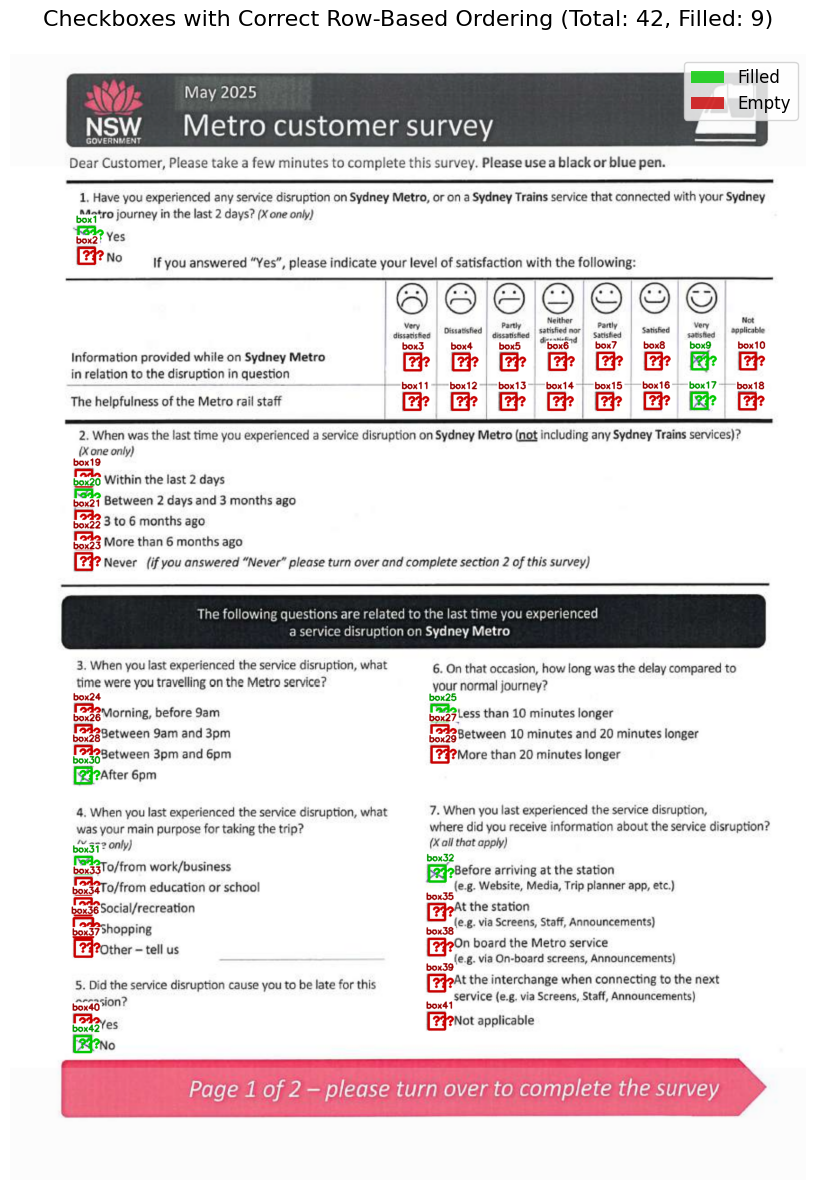


Checkbox layout analysis:
Row 1: box1✓ 
Row 2: box2✗ 
Row 3: box3✗ box4✗ box5✗ box6✗ box7✗ box8✗ box9✓ box10✗ 
Row 4: box11✗ box12✗ box13✗ box14✗ box15✗ box16✗ box17✓ box18✗ 
Row 5: box19✗ 
Row 6: box20✓ 
Row 7: box21✗ 
Row 8: box22✗ 
Row 9: box23✗ 
Row 10: box24✗ box25✓ 
Row 11: box26✗ box27✗ 
Row 12: box28✗ box29✗ 
Row 13: box30✓ 
Row 14: box31✓ 
Row 15: box32✓ 
Row 16: box33✗ 
Row 17: box34✗ box35✗ 
Row 18: box36✗ 
Row 19: box37✗ box38✗ 
Row 20: box39✗ 
Row 21: box40✗ box41✗ 
Row 22: box42✓ 



In [42]:
def sort_checkboxes_by_rows(checkboxes, row_tolerance=15):
    """Sort checkboxes by rows (top to bottom), then left to right within each row"""

    if not checkboxes:
        return []

    # First, group checkboxes into rows based on Y coordinate
    rows = []
    sorted_by_y = sorted(checkboxes, key=lambda cb: cb['bbox'][1])

    current_row = [sorted_by_y[0]]
    current_y = sorted_by_y[0]['bbox'][1]

    for checkbox in sorted_by_y[1:]:
        y = checkbox['bbox'][1]

        # If Y coordinate is close to current row, add to same row
        if abs(y - current_y) <= row_tolerance:
            current_row.append(checkbox)
        else:
            # Start new row
            rows.append(current_row)
            current_row = [checkbox]
            current_y = y

    # Don't forget the last row
    rows.append(current_row)

    # Sort each row by X coordinate (left to right)
    for row in rows:
        row.sort(key=lambda cb: cb['bbox'][0])

    # Flatten rows back into single list
    sorted_checkboxes = []
    for row in rows:
        sorted_checkboxes.extend(row)

    print(f"Detected {len(rows)} rows of checkboxes:")
    for i, row in enumerate(rows):
        y_coords = [cb['bbox'][1] for cb in row]
        print(f"  Row {i+1}: {len(row)} boxes at Y≈{sum(y_coords)//len(y_coords)}")

    return sorted_checkboxes

# Re-sort with proper row-based ordering
final_sorted_checkboxes = sort_checkboxes_by_rows(deduplicated_checkboxes, row_tolerance=15)

print("\nReordered checkboxes (by rows, then left-to-right):")
for i, checkbox in enumerate(final_sorted_checkboxes):
    x, y, w, h = checkbox['bbox']
    status = "✓ FILLED" if checkbox['is_filled'] else "✗ EMPTY"
    print(f"box{i+1}: {status} - Position: ({x:3}, {y:3})")

# Update DataFrame with corrected order
final_column_names = [f"box{i+1}" for i in range(len(final_sorted_checkboxes))]
final_checkbox_values = [checkbox['is_filled'] for checkbox in final_sorted_checkboxes]
final_df = pd.DataFrame([final_checkbox_values], columns=final_column_names)

print(f"\nUpdated DataFrame (proper row-based order):")
print(final_df)

#Cell: Visualize with Corrected Labels
# Create visualization with properly ordered labels
fig, ax = plt.subplots(figsize=(16, 12))

# Create a clean copy of the image
labeled_img = img.copy()

# Draw exclusion regions lightly
for ex_x1, ex_y1, ex_x2, ex_y2 in exclusion_regions:
    overlay = labeled_img.copy()
    cv2.rectangle(overlay, (ex_x1, ex_y1), (ex_x2, ex_y2), (240, 240, 240), -1)
    cv2.addWeighted(overlay, 0.2, labeled_img, 0.8, 0, labeled_img)

# Draw each checkbox with correct sequential labels
for i, checkbox in enumerate(final_sorted_checkboxes):
    x, y, w, h = checkbox['bbox']
    is_filled = checkbox['is_filled']

    # Choose colors
    if is_filled:
        box_color = (0, 200, 0)  # Green for filled
        text_color = (0, 150, 0)  # Darker green for text
    else:
        box_color = (200, 0, 0)  # Red for empty
        text_color = (150, 0, 0)  # Darker red for text

    # Draw checkbox rectangle
    cv2.rectangle(labeled_img, (x, y), (x + w, y + h), box_color, 3)

    # Draw box number with background for visibility
    box_label = f"box{i+1}"
    font_scale = 0.6
    thickness = 2

    # Get text size for background
    (text_width, text_height), baseline = cv2.getTextSize(box_label, cv2.FONT_HERSHEY_SIMPLEX,
font_scale, thickness)

    # Position label above the box
    label_x = x - 5
    label_y = y - 10

    # Draw white background for label
    cv2.rectangle(labeled_img,
                (label_x - 2, label_y - text_height - 2),
                (label_x + text_width + 2, label_y + 2),
                (255, 255, 255), -1)

    # Draw box number
    cv2.putText(labeled_img, box_label, (label_x, label_y),
                cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, thickness)

    # Draw fill status symbol in center of box
    status_symbol = "✓" if is_filled else "✗"
    symbol_x = x + w//2 - 8
    symbol_y = y + h//2 + 8
    cv2.putText(labeled_img, status_symbol, (symbol_x, symbol_y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, box_color, 3)

# Display the image
ax.imshow(labeled_img)
ax.set_title(f"Checkboxes with Correct Row-Based Ordering (Total: {len(final_sorted_checkboxes)}, Filled: {sum(final_checkbox_values)})",
            fontsize=16, pad=20)
ax.axis('off')

# Add legend
from matplotlib.patches import Rectangle
filled_patch = Rectangle((0, 0), 1, 1, fc=(0, 0.8, 0), alpha=0.8)
empty_patch = Rectangle((0, 0), 1, 1, fc=(0.8, 0, 0), alpha=0.8)
ax.legend([filled_patch, empty_patch], ['Filled', 'Empty'],
        loc='upper right', fontsize=12, frameon=True, facecolor='white')

plt.tight_layout()
plt.show()

# Show row structure
print(f"\nCheckbox layout analysis:")
current_y = None
row_num = 1
for i, checkbox in enumerate(final_sorted_checkboxes):
    x, y, w, h = checkbox['bbox']

    # Check if new row
    if current_y is None or abs(y - current_y) > 15:
        if current_y is not None:
            print()  # New line for new row
        print(f"Row {row_num}: ", end="")
        row_num += 1
        current_y = y

    status = "✓" if checkbox['is_filled'] else "✗"
    print(f"box{i+1}{status} ", end="")

print("\n")

In [46]:
custom_names = [
    "1. Yes",
    "1. No",
    "1b.",
    "1b.",
    "1b.",
    "1b.",
    "1b.",
    "1b.",
    "1b.",
    "1b.",
    "1b.",
    "1b.",
    "1b.",
    "1b.",
    "1b.",
    "1b.",
    "1b.",
    "1b.",
    "2.",
    "2.",
    "2.",
    "2.",
    "2.",

    "3.", #24
    "6.", #25
    "3.", #26
    "6.", #27
    "3.", #28
    "6.", #29
    "3.", #30

    "4.", #31
    "7.", #32
    "4.", #33
    "4.", #34
    "7.", #35
    "4.", #36
    "4.", #37
    "7.", #38
    "7.", #39
    "5.", #40
    "7.", #41
    "5.", #42
]

# Pad with default names if not enough custom names
while len(custom_names) < len(final_sorted_checkboxes):
    custom_names.append(f"box{len(custom_names)+1}")

# Create DataFrame with custom names
custom_df = pd.DataFrame([final_checkbox_values],
columns=custom_names[:len(final_sorted_checkboxes)])

print("DataFrame with custom column names:")
print(custom_df)

# Save mapping
mapping = {f"box{i+1}": custom_names[i] for i in range(len(final_sorted_checkboxes))}
with open('checkbox_names.json', 'w') as f:
    json.dump(mapping, f, indent=2)

# Show which boxes are filled with their custom names
print("\nFilled checkboxes:")
for i, (name, is_filled) in enumerate(zip(custom_names[:len(final_sorted_checkboxes)],
final_checkbox_values)):
    if is_filled:
        print(f"  ✓ {name} (was box{i+1})")

# Save with custom names
custom_df.to_csv("survey_results.csv", index=False)
print(f"\nSaved to survey_results.csv")

DataFrame with custom column names:
   1. Yes  1. No    1b.    1b.    1b.    1b.    1b.    1b.   1b.    1b.  ...  \
0    True  False  False  False  False  False  False  False  True  False  ...   

      4.     4.     7.     4.     4.     7.     7.     5.     7.    5.  
0  False  False  False  False  False  False  False  False  False  True  

[1 rows x 42 columns]

Filled checkboxes:
  ✓ 1. Yes (was box1)
  ✓ 1b. (was box9)
  ✓ 1b. (was box17)
  ✓ 2. (was box20)
  ✓ 6. (was box25)
  ✓ 3. (was box30)
  ✓ 4. (was box31)
  ✓ 7. (was box32)
  ✓ 5. (was box42)

Saved to survey_results.csv


In [50]:
custom_names = [
    "1_yes", "1_no",
    "1b_1", "1b_2", "1b_3", "1b_4", "1b_5", "1b_6", "1b_7", "1b_8", "1b_9", "1b_10", "1b_11",
"1b_12", "1b_13", "1b_14", "1b_15", "1b_16",
    "2_1", "2_2", "2_3", "2_4", "2_5",
    "3_1", "6_1", "3_2", "6_2", "3_3", "6_3", "3_4",
    "4_1", "7_1", "4_2", "4_3", "7_2", "4_4", "4_5", "7_3", "7_4", "5_1", "7_5", "5_2"
]

while len(custom_names) < len(final_sorted_checkboxes):
    custom_names.append(f"box{len(custom_names)+1}")

custom_df = pd.DataFrame([final_checkbox_values],
columns=custom_names[:len(final_sorted_checkboxes)])
custom_df.to_csv("survey_results.csv", index=False)
custom_df.head()


1_yes   1_no   1b_1   1b_2   1b_3   1b_4   1b_5   1b_6  1b_7   1b_8  ...  \
0   True  False  False  False  False  False  False  False  True  False  ...   

     4_2    4_3    7_2    4_4    4_5    7_3    7_4    5_1    7_5   5_2  
0  False  False  False  False  False  False  False  False  False  True  

[1 rows x 42 columns]

In [51]:
column_order = ["1_yes", "1_no"] + [f"1b_{i}" for i in range(1, 17)] + [f"2_{i}" for i in range(1,
6)] + [f"3_{i}" for i in range(1, 5)] + [f"4_{i}" for i in range(1, 6)] + [f"5_{i}" for i in range(1,
3)] + [f"6_{i}" for i in range(1, 4)] + [f"7_{i}" for i in range(1, 6)]

ordered_columns = [col for col in column_order if col in custom_df.columns]
ordered_df = custom_df[ordered_columns]
ordered_df.to_csv("survey_results_ordered.csv", index=False)
print(ordered_df)

   1_yes   1_no   1b_1   1b_2   1b_3   1b_4   1b_5   1b_6  1b_7   1b_8  ...  \
0   True  False  False  False  False  False  False  False  True  False  ...   

     5_1   5_2   6_1    6_2    6_3   7_1    7_2    7_3    7_4    7_5  
0  False  True  True  False  False  True  False  False  False  False  

[1 rows x 42 columns]


In [52]:
ordered_df

1_yes   1_no   1b_1   1b_2   1b_3   1b_4   1b_5   1b_6  1b_7   1b_8  ...  \
0   True  False  False  False  False  False  False  False  True  False  ...   

     5_1   5_2   6_1    6_2    6_3   7_1    7_2    7_3    7_4    7_5  
0  False  True  True  False  False  True  False  False  False  False  

[1 rows x 42 columns]